# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
from re import sub


import seaborn as sb
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_squared_error


**Столбцы**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

In [2]:
df = pd.read_csv('/datasets/autos.csv')
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Отсутствуют сильно коррелирующие признаки

<AxesSubplot:>

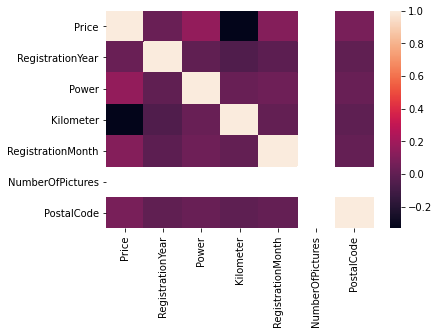

In [3]:
sb.heatmap(df.corr())

In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Данные содержат артефакты, такие как RegistrationYear = 9999,  Power = 0

Для определения рыночной стоимости часть столбцов не потребуется. Оставим только следующие столбцы:

- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет


In [5]:
df = df.drop(['DateCrawled','RegistrationMonth','DateCreated',
'NumberOfPictures',
'PostalCode',
'LastSeen'],axis=1)

Переименуем столбцы

In [6]:
for name in df.columns:
    rena = sub(r"(?=[A-Z])(?!^)", '_', name).lower()
    df = df.rename(columns={name:rena})

Удалим строки в которых неизвестна модель автомобиля, так как это ключевый признак для определения цены и заполнить его невозможно. Пропуски в остальных признаках заполним как "неизвестно"

In [7]:
df['not_repaired'] = df['not_repaired'].fillna('неизвестно')
df['fuel_type'] = df['fuel_type'].fillna('неизвестно')
df['vehicle_type'] = df['vehicle_type'].fillna('неизвестно')
df['gearbox'] = df['gearbox'].fillna('неизвестно')

In [8]:
df = df.dropna()

In [9]:
df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
not_repaired         0
dtype: int64

Выделим обучающие и целевые признаки:

price [    0     1     2 ... 19998 19999 20000]


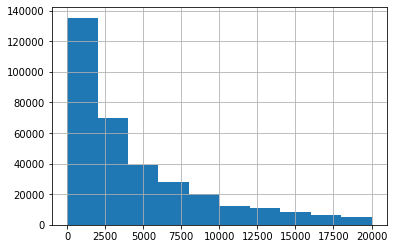

vehicle_type ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon'
 'неизвестно']


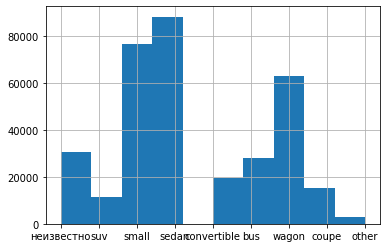

registration_year [1000 1001 1111 1200 1234 1300 1400 1500 1600 1602 1800 1910 1919 1923
 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1941 1942
 1943 1945 1947 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959
 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2066 2200 2290 2500 2900 3000 3700 4000 4500 5000
 5555 5900 5911 6000 6500 7000 7100 7500 7800 8000 8200 8500 9000 9999]


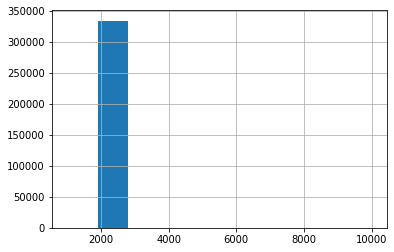

gearbox ['auto' 'manual' 'неизвестно']


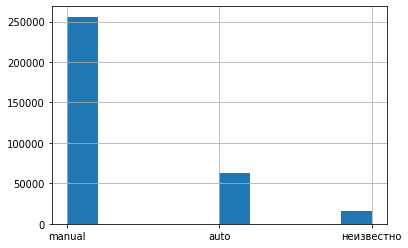

power [    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98    99   100   101   102   103   104   105   106   107
   108   109   110   111   112   113   114   115   116   117   118   119
   120   121   122   123   124   125   126   127   128   129   130   131
   132   133   134   135   136   137   138   139   140   141   142   143
   144   145   146   147   148   149   150   151   152   153   154   155
   156   157   158   159   160   161   162   

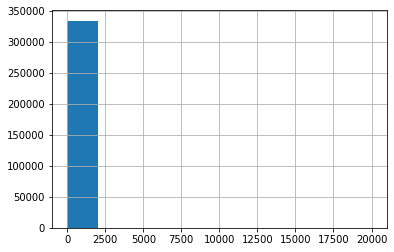

model ['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fox' 'freelander' 'fusion' 'g_klasse' 'galant'
 'galaxy' 'getz' 'gl' 'glk' 'golf' 'grand' 'i3' 'i_reihe' 'ibiza'
 'impr

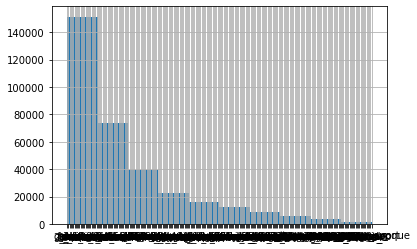

kilometer [  5000  10000  20000  30000  40000  50000  60000  70000  80000  90000
 100000 125000 150000]


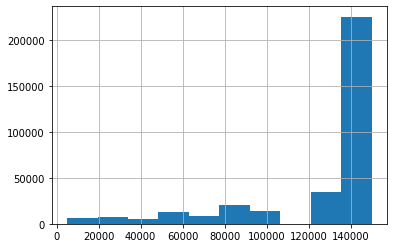

fuel_type ['cng' 'electric' 'gasoline' 'hybrid' 'lpg' 'other' 'petrol' 'неизвестно']


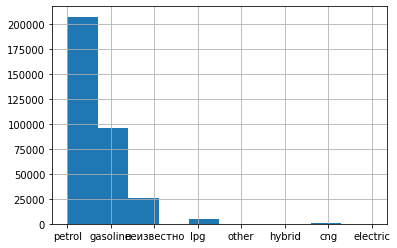

brand ['alfa_romeo' 'audi' 'bmw' 'chevrolet' 'chrysler' 'citroen' 'dacia'
 'daewoo' 'daihatsu' 'fiat' 'ford' 'honda' 'hyundai' 'jaguar' 'jeep' 'kia'
 'lada' 'lancia' 'land_rover' 'mazda' 'mercedes_benz' 'mini' 'mitsubishi'
 'nissan' 'opel' 'peugeot' 'porsche' 'renault' 'rover' 'saab' 'seat'
 'skoda' 'smart' 'subaru' 'suzuki' 'toyota' 'trabant' 'volkswagen' 'volvo']


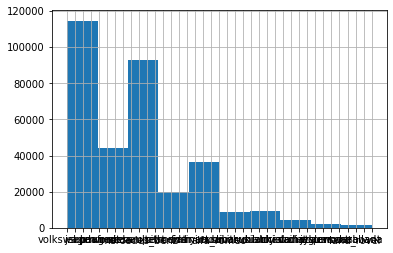

not_repaired ['no' 'yes' 'неизвестно']


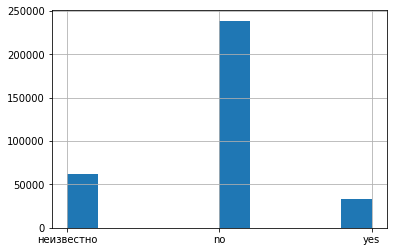

In [10]:
for column in df.columns:
    print(column, df[column].sort_values().unique())
    df[column].hist()
    plt.show()

<AxesSubplot:xlabel='registration_year'>

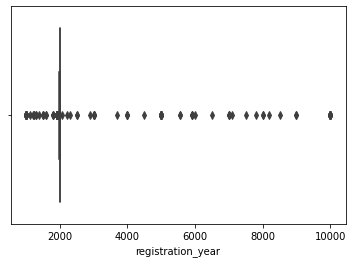

In [11]:
sb.boxplot(x=df['registration_year'])

<AxesSubplot:xlabel='registration_year'>

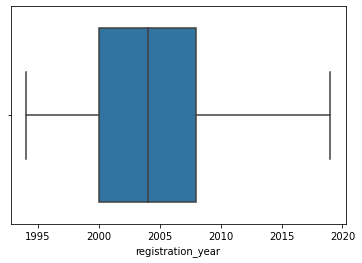

In [12]:
df = df[(df['registration_year']<2022) & (df['registration_year']>df['registration_year'].quantile(0.05))]
sb.boxplot(x=df['registration_year'])

<AxesSubplot:xlabel='power'>

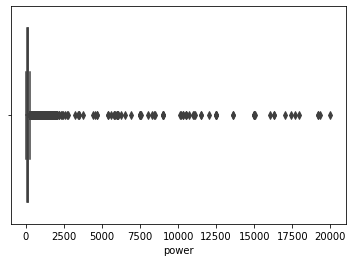

In [13]:
sb.boxplot(x=df['power'])

In [14]:
df = df.loc[(df['power']>39) & (df['power']<550)]

<AxesSubplot:xlabel='power'>

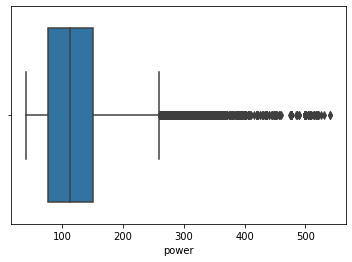

In [15]:
sb.boxplot(x=df['power'])

<AxesSubplot:xlabel='price'>

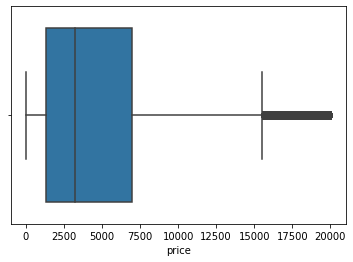

In [16]:
sb.boxplot(x=df['price'])

In [17]:
df = df[df.price>500]

In [18]:
#код ревьюера
df.describe(include='all')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
count,260793.000000,260793,260793.00000,260793,260793.000000,260793,260793.000000,260793,260793,260793
unique,NaN,9,NaN,3,NaN,247,NaN,8,38,3
top,NaN,sedan,NaN,manual,NaN,golf,NaN,petrol,volkswagen,no
freq,NaN,71071,NaN,202941,NaN,22083,NaN,158148,56218,207064
mean,5254.617754,NaN,2004.51432,NaN,123.657123,NaN,127690.428808,NaN,NaN,NaN
std,4605.469753,NaN,5.41487,NaN,53.020391,NaN,36711.515311,NaN,NaN,NaN
min,501.000000,NaN,1994.00000,NaN,40.000000,NaN,5000.000000,NaN,NaN,NaN
25%,1650.000000,NaN,2000.00000,NaN,83.000000,NaN,125000.000000,NaN,NaN,NaN
50%,3600.000000,NaN,2004.00000,NaN,116.000000,NaN,150000.000000,NaN,NaN,NaN
75%,7500.000000,NaN,2008.00000,NaN,150.000000,NaN,150000.000000,NaN,NaN,NaN


In [19]:
target = df['price']
features = df.drop(['price'], axis=1)

In [20]:
features_OHE = pd.get_dummies(features[['vehicle_type','gearbox','fuel_type','not_repaired']],drop_first=True)

In [21]:
features_OHE.head()

,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,vehicle_type_неизвестно,gearbox_manual,gearbox_неизвестно,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_неизвестно,not_repaired_yes,not_repaired_неизвестно
2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
6,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


Категориальные признаки которые имеют много различных значений, закодируем числовыми метками.

In [22]:
features_encoder = df[['brand','model']].apply(LabelEncoder().fit_transform) 

In [23]:
cat_features = ['vehicle_type','gearbox','model','fuel_type','brand','not_repaired']

В *features_preproc* лежат данные с предобработанными категориальными признаками, для простых моделей

In [24]:
features_preproc = df.drop(cat_features,axis=1)
features_preproc = features_preproc.drop('price', axis = 1)
features_preproc[features_encoder.columns] = features_encoder
features_preproc[features_OHE.columns] = features_OHE

In [25]:
features_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260793 entries, 2 to 354368
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   registration_year         260793 non-null  int64
 1   power                     260793 non-null  int64
 2   kilometer                 260793 non-null  int64
 3   brand                     260793 non-null  int64
 4   model                     260793 non-null  int64
 5   vehicle_type_convertible  260793 non-null  uint8
 6   vehicle_type_coupe        260793 non-null  uint8
 7   vehicle_type_other        260793 non-null  uint8
 8   vehicle_type_sedan        260793 non-null  uint8
 9   vehicle_type_small        260793 non-null  uint8
 10  vehicle_type_suv          260793 non-null  uint8
 11  vehicle_type_wagon        260793 non-null  uint8
 12  vehicle_type_неизвестно   260793 non-null  uint8
 13  gearbox_manual            260793 non-null  uint8
 14  gearbox_неизвестно  

In [26]:
features_preproc_train,features_preproc_test, target_preproc_train, target_preproc_test = train_test_split(features_preproc,target,test_size=0.25,random_state=1234)

In [27]:
print(features_preproc_train.shape,features_preproc_test.shape, target_preproc_train.shape, target_preproc_test.shape)

(195594, 24) (65199, 24) (195594,) (65199,)


In [28]:
features_train,features_test, target_train, target_test = train_test_split(features,target,test_size=0.25,random_state=1234)


In [29]:
print(features_train.shape,features_test.shape, target_train.shape, target_test.shape)

(195594, 9) (65199, 9) (195594,) (65199,)


## Обучение моделей

### Линейная регрессия

In [30]:
model_LR = LinearRegression()
score_LR = -cross_val_score(model_LR, features_preproc_train, target_preproc_train, 
                             scoring='neg_root_mean_squared_error',
                             cv = 3).mean()

model_LR.fit(features_preproc_train, target_preproc_train)

print(score_LR)

2513.300711264126


### Случайный лес

Подбор параметров на обучающей выборке

In [34]:
%%time
rfr = RandomForestRegressor()

parametrs = { 'n_estimators': range (80, 150,30),
              'max_depth': range (13,17, 3),
            'max_features':range (10,21, 10)}

grid_RFR = GridSearchCV(rfr, parametrs, cv=3,scoring='neg_root_mean_squared_error',verbose=10)
grid_RFR.fit(features_preproc_train, target_preproc_train)
print(grid_RFR.best_params_)
print(grid_RFR.best_score_)

In [31]:
rfr = RandomForestRegressor(max_depth= 16, max_features=10, n_estimators= 140)
score_RFR = -cross_val_score(rfr, features_preproc_train, target_preproc_train, 
                             scoring='neg_root_mean_squared_error',
                             cv = 3).mean()
print(score_RFR)

1518.7275219430203


### Градиентный бустинг CatBoost

In [36]:
model_CBR = CatBoostRegressor( cat_features=cat_features,loss_function="RMSE",verbose=False)

grid = {'iterations': range(80, 150,30),
        'depth': range(13, 17, 3),
        }

grid_CBR = GridSearchCV(estimator=model_CBR,param_grid=grid,
                                       verbose = 20,
                                       scoring = 'neg_root_mean_squared_error',
                          cv = 3)

grid_CBR.fit(features_train,target_train)
print(grid_CBR.best_params_)
print(grid_CBR.best_score_)

In [32]:
cbr = CatBoostRegressor(depth = 13, iterations = 140,cat_features=cat_features,loss_function="RMSE",verbose=False)
score_CBR = -cross_val_score(cbr, features_train, target_train, 
                             scoring='neg_root_mean_squared_error',
                             cv = 3).mean()
print(score_CBR)

1499.8189609876433


### Градиентный бустинг LightGBM

Обучение модели на заранее обработанных катогериальных признаках

In [38]:
%%time
model_LGBM = LGBMRegressor()
grid = {'max_depth': range(16,30,3),
        'n_estimators': range(140,200,30),
        }

grid_LGBM = GridSearchCV(estimator=model_LGBM,param_grid=grid,
                                       verbose = 20,
                                       scoring = 'neg_root_mean_squared_error',
                          cv = 3)
grid_LGBM.fit(features_preproc_train, target_preproc_train)
print(grid_LGBM.best_params_)
print(grid_LGBM.best_score_)

Обучение модели без заранее обработанных катогериальных признаках

In [33]:
features_train[cat_features] = features_train[cat_features].astype('category')

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
%%time
model_LGBM = LGBMRegressor()
grid = {'max_depth': range(16,30,3),
        'n_estimators': range(140,200,30),
        }

grid_LGBM = GridSearchCV(estimator=model_LGBM,param_grid=grid,
                                       verbose = 20,
                                       scoring = 'neg_root_mean_squared_error',
                          cv = 3)

grid_LGBM.fit(features_train, target_train)
print(grid_LGBM.best_params_)
print(grid_LGBM.best_score_)

In [35]:
lgbm = LGBMRegressor(max_depth = 16, n_estimators= 170)
score_LGBM = -cross_val_score(lgbm, features_train, target_train, 
                             scoring='neg_root_mean_squared_error',
                             cv = 3).mean()
print(score_LGBM)

1512.057806132411


### Вычисление времени обучения отобранных моделей

In [36]:
%%time

model_LR.fit(features_preproc_train, target_preproc_train)

CPU times: user 258 ms, sys: 93.1 ms, total: 351 ms
Wall time: 314 ms


LinearRegression()

In [37]:
%%time
rfr.fit(features_preproc_train, target_preproc_train)

CPU times: user 33.7 s, sys: 110 ms, total: 33.8 s
Wall time: 33.8 s


RandomForestRegressor(max_depth=16, max_features=10, n_estimators=140)

In [38]:
%%time
cbr.fit(features_train, target_train)

CPU times: user 31.2 s, sys: 143 ms, total: 31.4 s
Wall time: 31.8 s


In [41]:
%%time
lgbm.fit(features_train, target_train)

CPU times: user 5.69 s, sys: 13.5 ms, total: 5.71 s
Wall time: 5.76 s


LGBMRegressor(max_depth=16, n_estimators=170)

In [151]:
new_rows = {'model':['Linear','RandomForest','CatBoost','LGBM'], 'RMSE':[score_LR,score_RFR,score_CBR,score_LGBM] , 'time':[0.314,33.8,31.8,5.76]}
df_result = pd.DataFrame(data=new_rows,columns=['model','RMSE','time'])
df_result.sort_values('RMSE')

Cамый быстрый результат показала модель - LGBM. Самый точный - CatBoost

## Анализ моделей

Проверим лучшую модель на тестовых данных

In [42]:
features_test[cat_features] = features_test[cat_features].astype('category')
predict = lgbm.predict(features_test)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [43]:
mean_squared_error(target_test,predict)**0.5

1504.9905598468815

**Выводы:** наилучшую скорость обучения показала модель LGBM, при этом ошибка наименьшая у модели CatBoost. Так как заказчику кроме точности важна и скорость, рекомендуется использовать модель LGBM, преимущество в скорости значительно превосходит преимущество по точности.